## Problema de negócio: 
As vendas da empresa estão negativamente sendo diretamente impactadas com os atrasos nas entregas, criando insatisfação nos clientes e aumento consideravelmente os custos operacionais. O não conhecimento em relação aos  padrões de compra dificulta a personalização das ofertas e o planejamento eficiente do estoque.  
Devido a isso, deve-se utilizar dados para poder gerar insights, a fim de otimizar processos logísticos, entender padrões de compra e desenvolver um modelo de Machine Learning capaz de prever atrasos nas entregas das compras.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, round
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
# Criando a SparkSession
spark = SparkSession.builder \
    .appName("SupplyChainAnalysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .master("local[*]") \
    .getOrCreate()

sqlContext = SQLContext(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/22 03:20:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Análise Exploratória

In [3]:
# Carga dos dados
dados = pd.read_csv("dados/DataCoSupplyChainDataset.csv", encoding='latin1')

In [4]:
# Amostra de dados
dados.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [5]:
# Shape
dados.shape

(180519, 53)

In [6]:
# Colunas
dados.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [7]:
# Info
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [8]:
# Verificando valores ausentes
dados.apply(lambda x: sum(x.isnull()))

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [9]:
# Tipos de dados
dados.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Delivery Status                   object
Late_delivery_risk                 int64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Email                    object
Customer Fname                    object
Customer Id                        int64
Customer Lname                    object
Customer Password                 object
Customer Segment                  object
Customer State                    object
Customer Street                   object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Latitude                         float64
Longitude                        float64
Market          

In [10]:
# Juntar nome e sobrenome
dados['Customer Name'] = dados['Customer Fname'].astype(str) + dados['Customer Lname'].astype(str)

In [11]:
# Dropar colunas desnecessárias
dados.drop(columns=[
    'Product Status', 'Customer Password', 'Customer Email', 'Customer Street', 'Customer Fname', 
    'Customer Lname', 'Latitude', 'Longitude', 'Product Image', 'Product Description', 
    'Order Zipcode', 'shipping date (DateOrders)'], inplace=True)

In [12]:
# Atribuir o valor zero para os valores ausentes da coluna 'Customer Zipcode'
dados['Customer Zipcode'].fillna(0, inplace=True)

/var/folders/d4/kxcmqn4s2hzf41sdcw6gkww00000gn/T/ipykernel_1049/701555974.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['Customer Zipcode'].fillna(0, inplace=True)


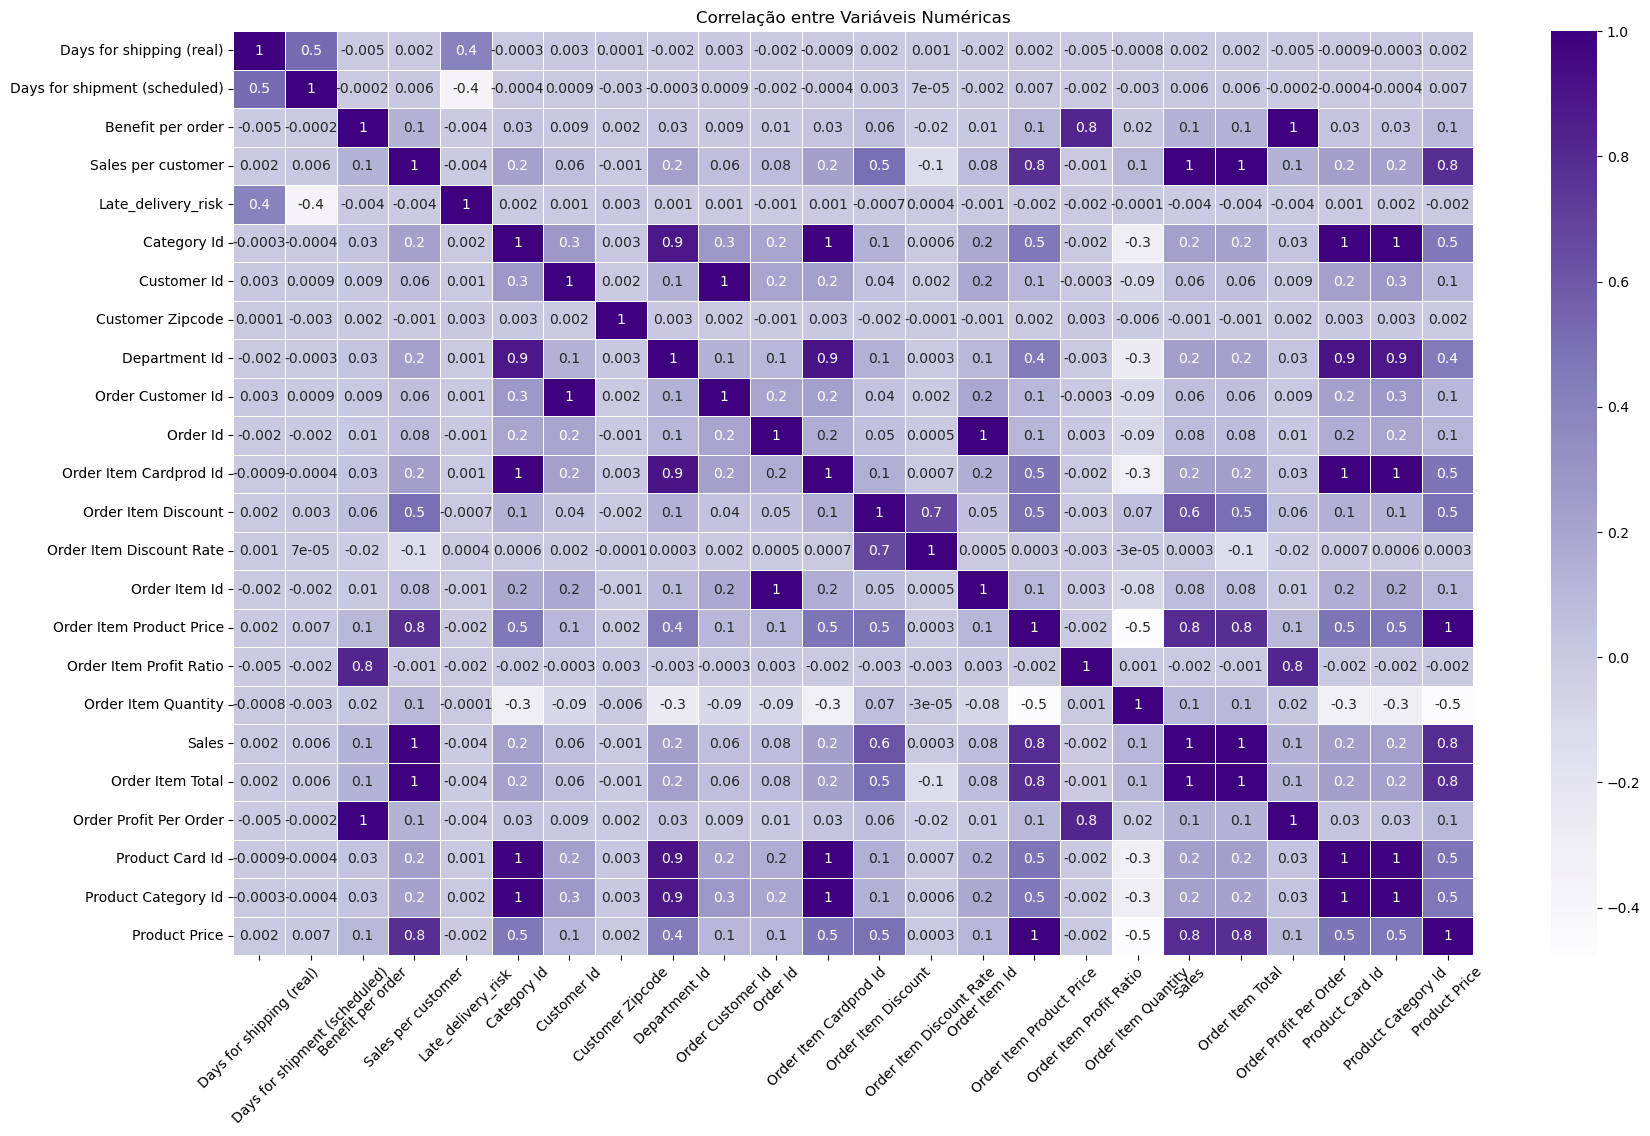

In [13]:
# Corr. entre as var. numéricas
plt.figure(figsize=(20, 12))
sns.heatmap(dados.select_dtypes(include=['number']).corr(), annot=True, linewidths=.5, fmt='.1g', cmap='Purples')
plt.title("Correlação entre Variáveis Numéricas")
plt.xticks(rotation=45)
plt.show()

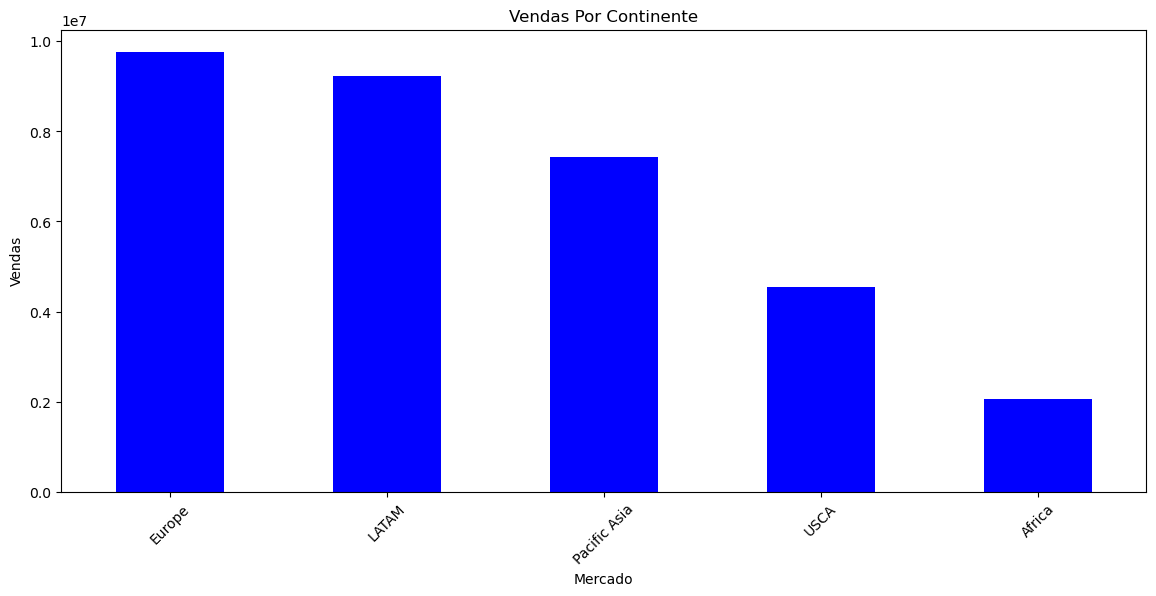

In [14]:
# Vendas por Continente
dados.groupby('Market')['Sales per customer'].sum().sort_values(ascending=False).plot.bar(
    figsize=(14,6), color='blue', title="Vendas Por Continente")
plt.xlabel("Mercado")
plt.ylabel("Vendas")
plt.xticks(rotation=45)
plt.show()

A partir do gráfico acima podemos observar que o mercado europeu e latino americano possuem o maior número de vendas enquanto que a África apresenta o menor número de vendas.

In [15]:
# Agrupa por Order Region
grupo_regiao = dados.groupby('Order Region')

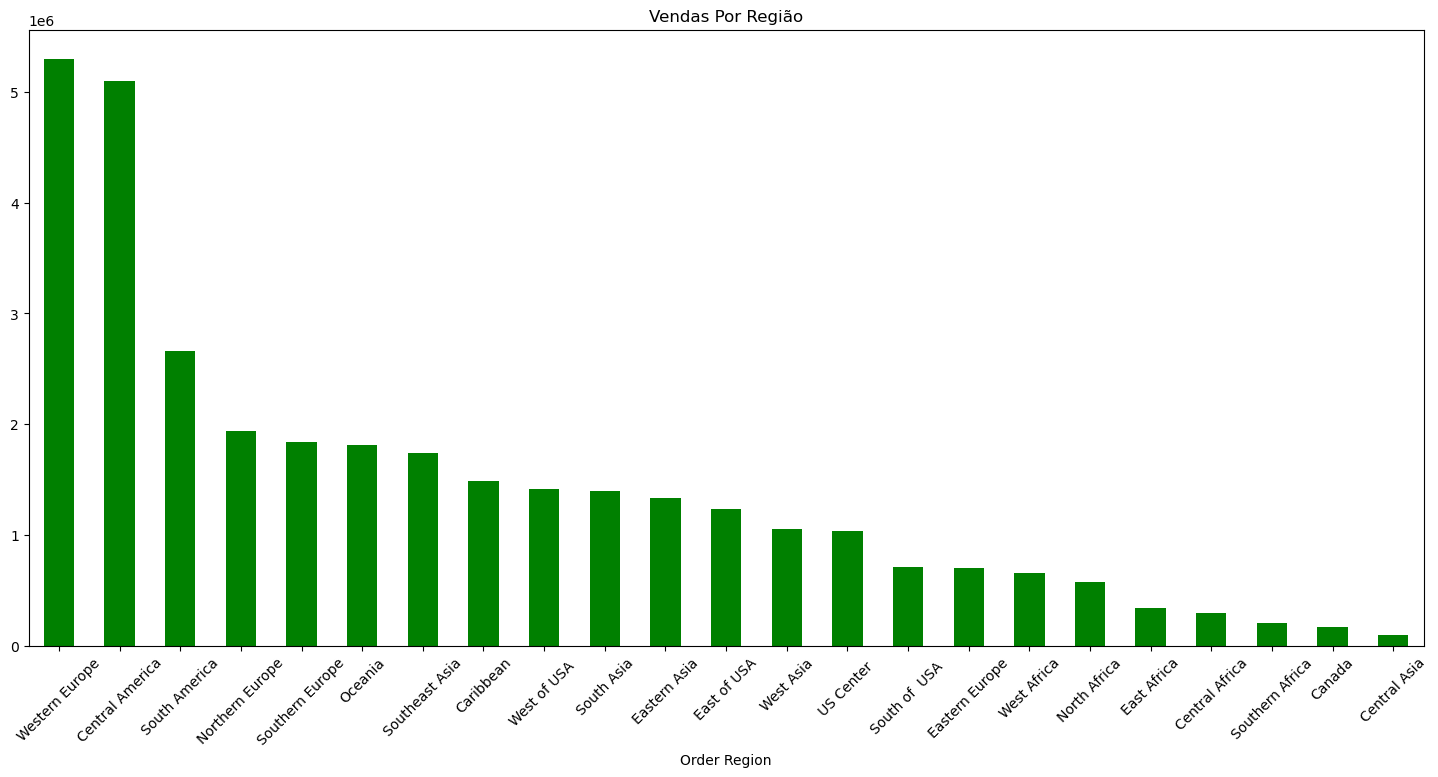

In [16]:
# Plotando
plt.figure(2)
grupo_regiao['Sales per customer'].sum().sort_values(ascending = False).plot.bar(figsize = (18,8), 
                                                                                 color = ['green'], 
                                                                                 title = "Vendas Por Região")
plt.xticks(rotation=45)
plt.show()

No gráfico acima nota-se que a região da Europa Ocidental e a região da América Central registraram o maior volume de vendas, enquanto a Ásia Central registrou o menor volume de vendas. Ou seja, há regiões da Africa que possuem um mercado mais significativo comparado ao Canada e na Ásia Central, como estava camuflado a partir do gráfico anterior.

In [17]:
# Agrupando os dados por categoria
categoria = dados.groupby('Category Name')

<Axes: title={'center': 'Vendas por Categoria'}, ylabel='Category Name'>

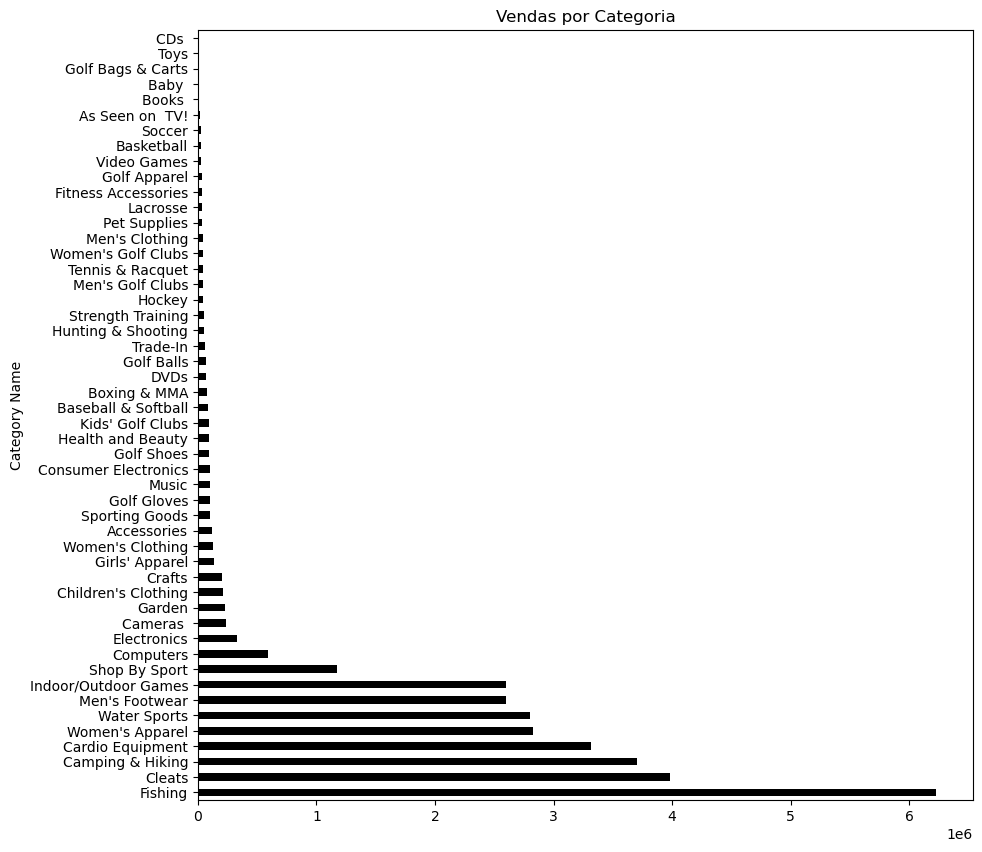

In [18]:
# Plot
plt.figure(1)
categoria['Sales per customer'].sum().sort_values(ascending = False).plot.barh(figsize = (10,10), 
                                                                              color = ['black'], 
                                                                              title = "Vendas por Categoria")

<Axes: title={'center': 'Média de Vendas Por Categoria'}, ylabel='Category Name'>

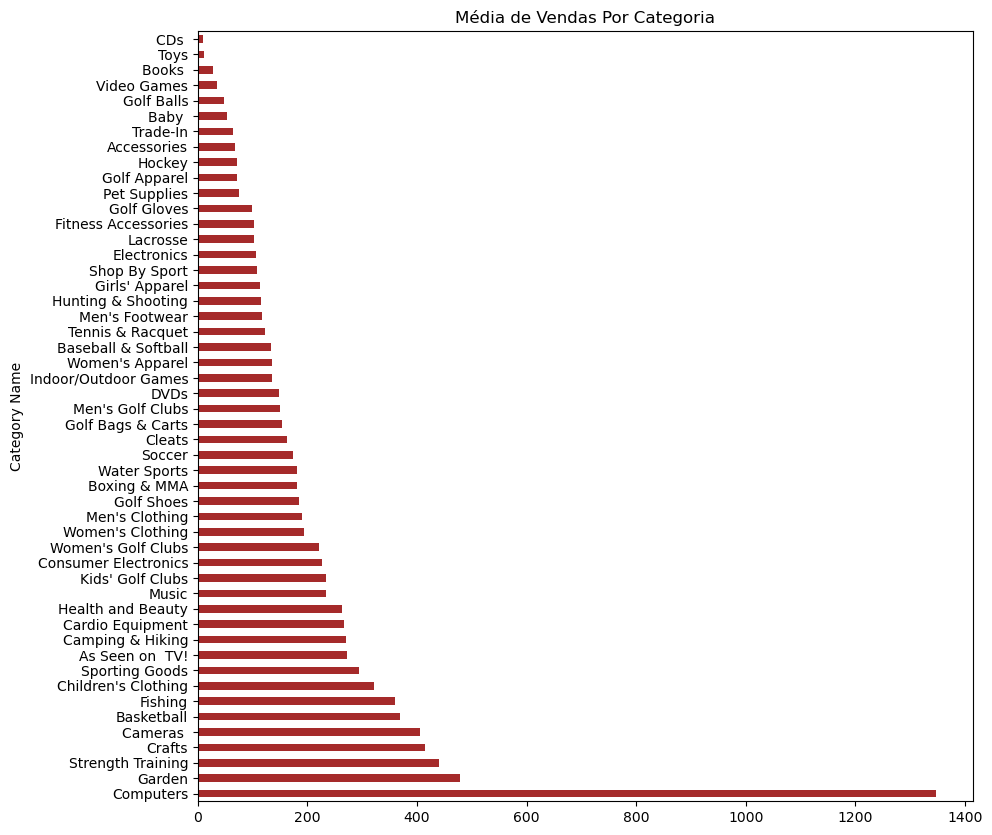

In [19]:
# Média de vendas por categoria
plt.figure(2)
categoria['Sales per customer'].mean().sort_values(ascending = False).plot.barh(figsize = (10,10), 
                                                                               color = ['brown'],
                                                                               title = "Média de Vendas Por Categoria")

<Axes: title={'center': 'Preço Médio Por Categoria'}, ylabel='Category Name'>

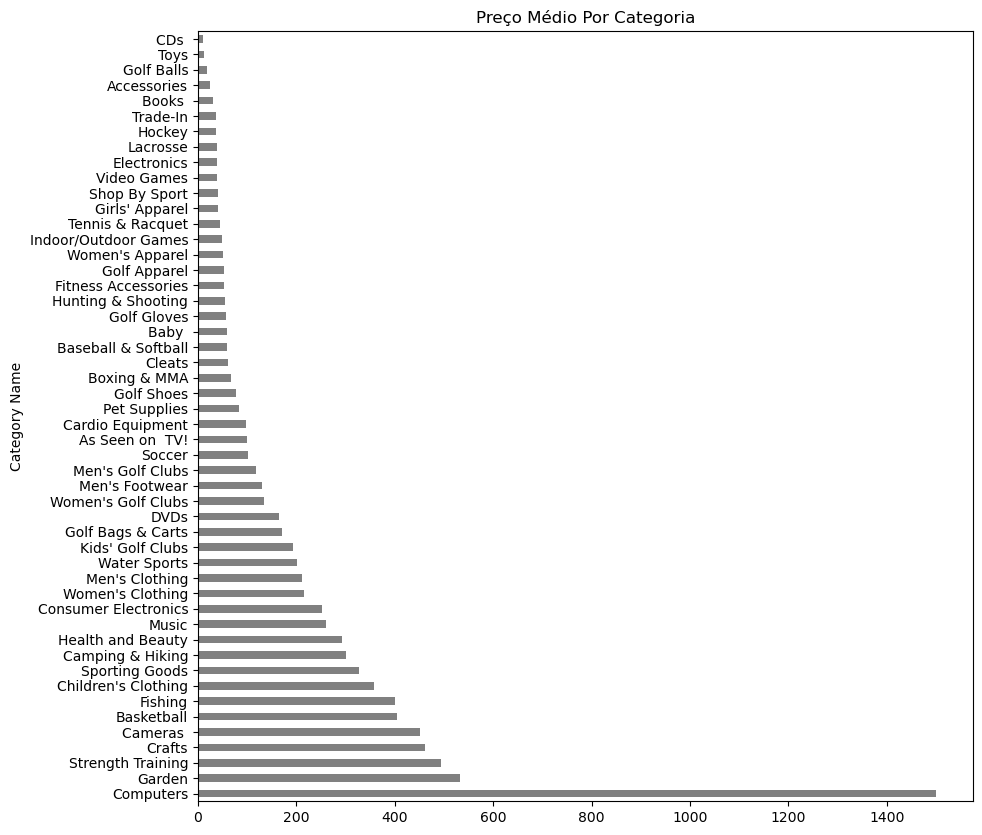

In [20]:
# Preço Médio de venda por categoria
plt.figure(3)
categoria['Product Price'].mean().sort_values(ascending = False).plot.barh(figsize = (10,10), 
                                                                          color = ['gray'], 
                                                                          title = "Preço Médio Por Categoria")

Os produtos com os as médias de preços mais altos, são os que têm em média, maior número de vendas. Por exemplo os Computers vendendo cerca de 1.400 unidades, mesmo seu preço médio esta próximo de US$ 1.500.

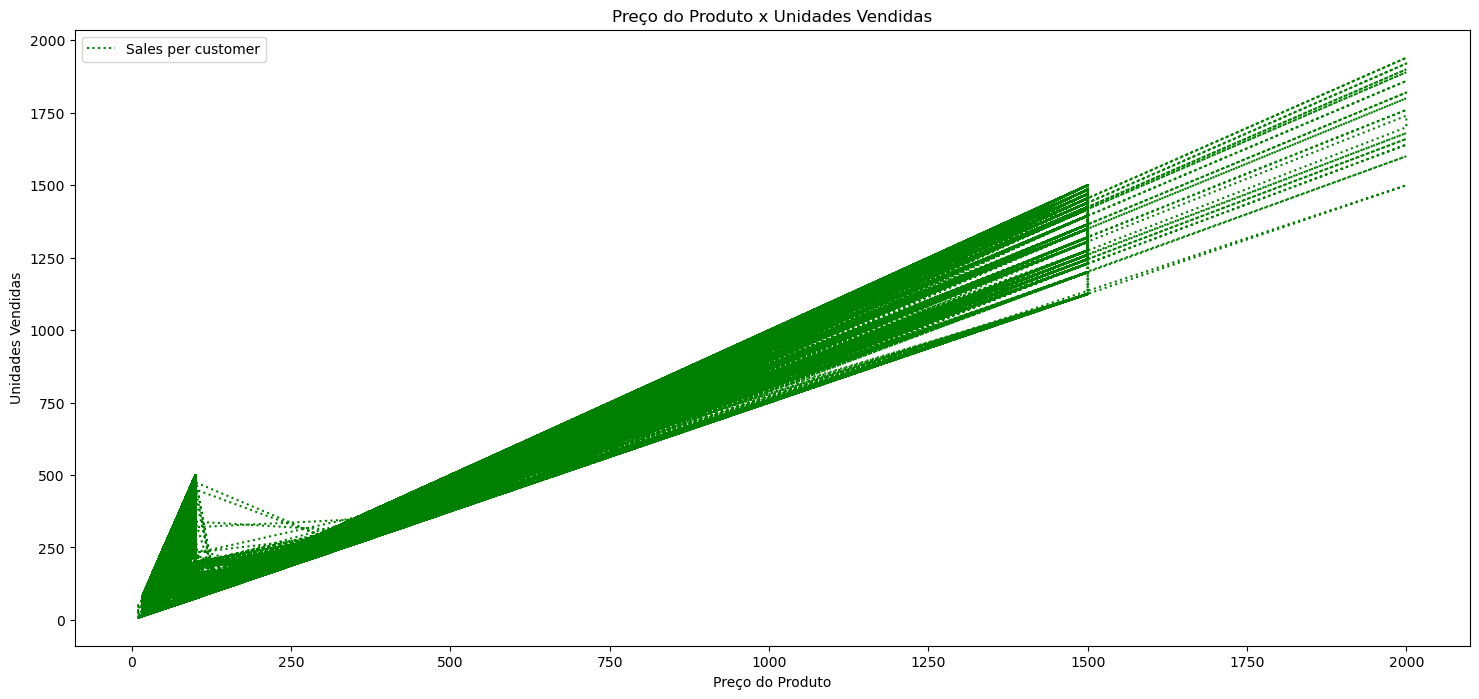

In [21]:
# Plot
dados.plot(x = 'Product Price', 
           y = 'Sales per customer',
           linestyle = 'dotted',
           markerfacecolor = 'green', 
           markersize = 12, 
           color = ['green'], 
           figsize = (18,8)) 
plt.title('Preço do Produto x Unidades Vendidas')
plt.xlabel('Preço do Produto')
plt.ylabel('Unidades Vendidas') 
plt.show()

O preço do produto apresenta uma clara correlação positiva com as unidades vendidas.

In [22]:
# Cópia do DF
df = dados.copy()

In [23]:
# Associando clientes e produtos
df = df[['Customer Name', 'Product Name']]
df = df.drop_duplicates(['Customer Name', 'Product Name'])
df = df.groupby('Customer Name')['Product Name'].apply(list).reset_index(name = "Products")

In [24]:
df.head()

,Customer Name,Products
0,AaronBerger,[Under Armour Girls' Toddler Spine Surge Runni...
1,AaronBoyle,[Diamondback Women's Serene Classic Comfort Bi...
2,AaronBush,"[Nike Men's CJ Elite 2 TD Football Cleat, Unde..."
3,AaronCalhoun,"[Perfect Fitness Perfect Rip Deck, Pelican Sun..."
4,AaronCarr,"[Pelican Sunstream 100 Kayak, Nike Men's CJ El..."


In [25]:
type(df)

pandas.core.frame.DataFrame

In [26]:
dados.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State',
       'Customer Zipcode', 'Department Id', 'Department Name', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'Shipping Mode', 'Customer Name'],
      dtype='object')

In [27]:
# Total de registros pelo tipo de pagamento
dados['Type'].value_counts()

Type
DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: count, dtype: int64

In [28]:
# Total de registros pelo risco de atraso na entrega
dados['Late_delivery_risk'].value_counts()

Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64

In [29]:
# Total de compras por cliente
dados['Customer Name'].value_counts() 

Customer Name
MarySmith           23884
RobertSmith           744
JamesSmith            726
DavidSmith            723
JohnSmith             645
                    ...  
KevynChristensen        1
KarleighConley          1
LindaWorkman            1
MariBeach               1
HyacinthWitt            1
Name: count, Length: 14033, dtype: int64

In [30]:
# Total de registros pelo número de dias de envio
dados['Days for shipment (scheduled)'].value_counts()

Days for shipment (scheduled)
4    107752
2     35216
1     27814
0      9737
Name: count, dtype: int64

In [31]:
# Total de registros por região
dados['Order Region'].value_counts()

Order Region
Central America    28341
Western Europe     27109
South America      14935
Oceania            10148
Northern Europe     9792
Southeast Asia      9539
Southern Europe     9431
Caribbean           8318
West of USA         7993
South Asia          7731
Eastern Asia        7280
East of USA         6915
West Asia           6009
US Center           5887
South of  USA       4045
Eastern Europe      3920
West Africa         3696
North Africa        3232
East Africa         1852
Central Africa      1677
Southern Africa     1157
Canada               959
Central Asia         553
Name: count, dtype: int64

In [32]:
# Total de registros pelo modo de envio
dados['Shipping Mode'].value_counts()

Shipping Mode
Standard Class    107752
Second Class       35216
First Class        27814
Same Day            9737
Name: count, dtype: int64

In [33]:
# Criando coluna para demora da entrega
dados['Shipping Delay'] = dados['Days for shipping (real)'] - dados['Days for shipment (scheduled)']

In [34]:
# Dropando colunas não importantes
dados.drop(columns=['Product Price', 'Category Id', 'Order Id', 'Product Category Id', 'Order Item Id',
                    'Product Card Id', 'Order Item Cardprod Id', 'Customer Id', 'Order Customer Id',
                    'Department Id', 'Customer Zipcode'], inplace=True)

In [35]:
# Shape
dados.shape

(180519, 32)

In [36]:
dados.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Country,...,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Name,Shipping Mode,Customer Name,Shipping Delay
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,...,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,Smart watch,Standard Class,CallyHolloway,-1
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,...,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,Smart watch,Standard Class,IreneLuna,1
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,...,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,Smart watch,Standard Class,GillianMaldonado,0
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,...,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,Smart watch,Standard Class,TanaTate,-1
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,...,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,Smart watch,Standard Class,OrliHendricks,-2


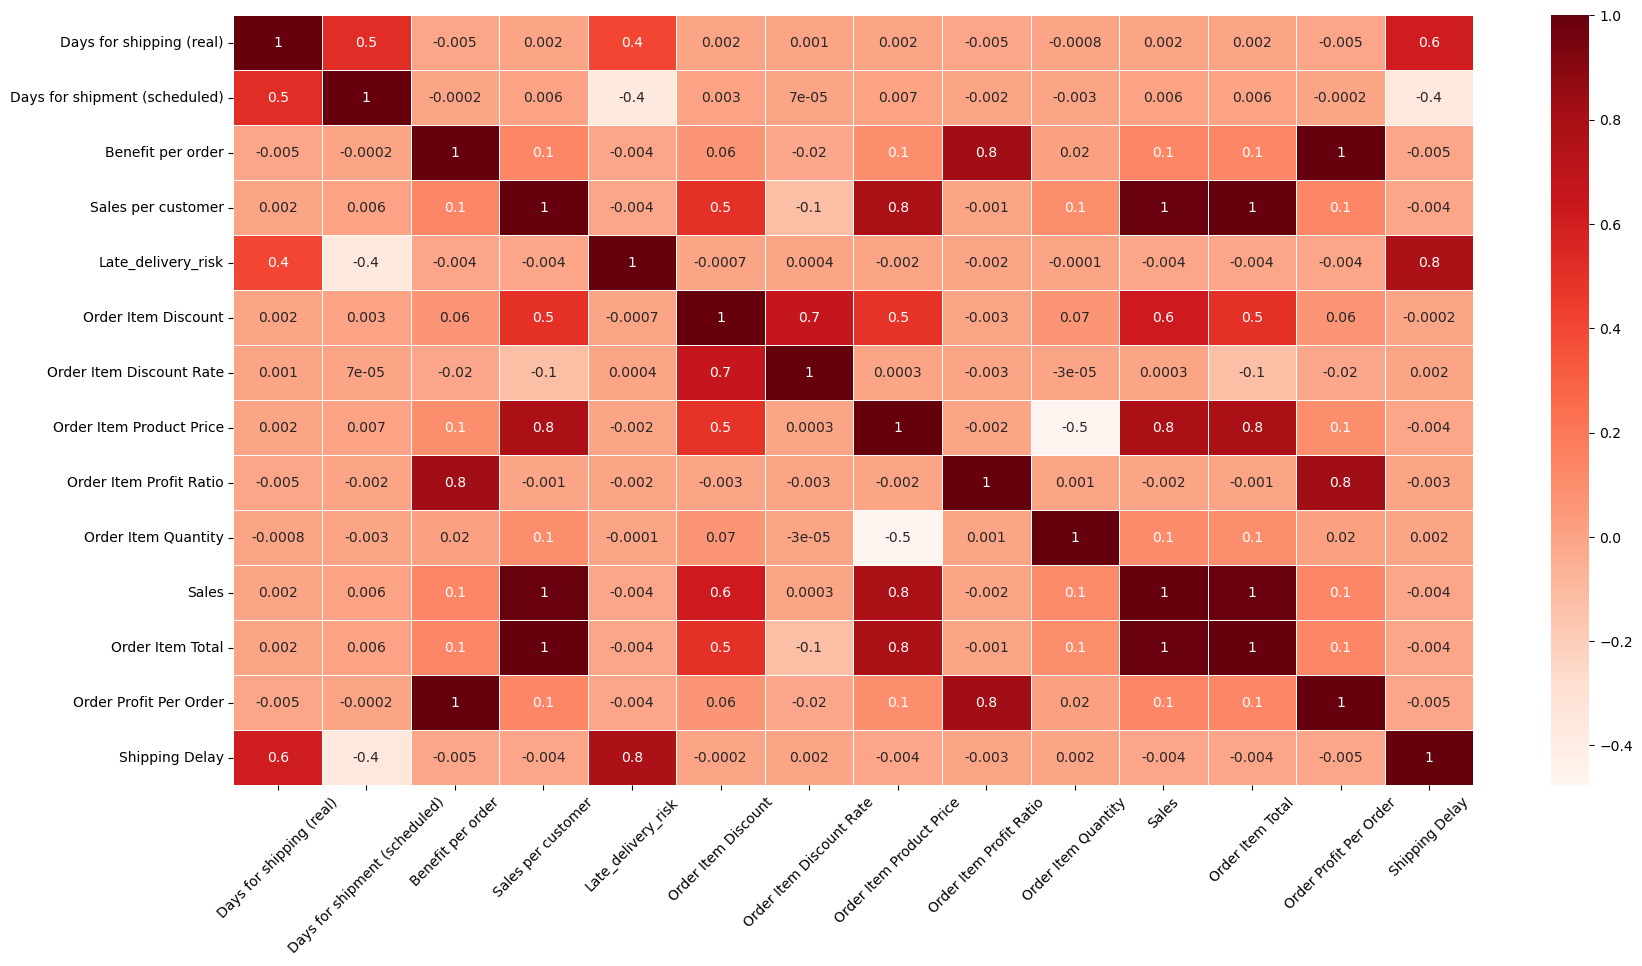

In [37]:
# Correlação
dados_numericos = dados.select_dtypes(include=['number'])
fig, ax = plt.subplots(figsize = (20,10))    
sns.heatmap(dados_numericos.corr(), annot = True, linewidths = .5, fmt = '.1g', cmap = 'Reds') 
plt.xticks(rotation=45)
plt.show()

### Regras de Associação

In [38]:
# Convertendo em um DF do Spark
df_spark = spark.createDataFrame(dados)

In [39]:
# Frequent Pattern Mining (FPGrowth)
df_transactions = df_spark.select("Customer Name", "Product Name").dropDuplicates()
df_transactions = df_transactions.groupby("Customer Name").agg(
    pyspark.sql.functions.collect_list("Product Name").alias("Products"))

In [40]:
# Frequent Pattern Mini
fpGrowth = FPGrowth(itemsCol="Products", minSupport=0.015, minConfidence=0.35)

In [41]:
# Treina o modelo
modelo_fp = fpGrowth.fit(df_transactions)

25/02/22 03:20:51 WARN TaskSetManager: Stage 0 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:20:56 WARN TaskSetManager: Stage 3 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.


In [42]:
# Itens que ocorrem com mais frequência
modelo_fp.freqItemsets.sort('freq', ascending = False).show(truncate = False)

+------------------------------------------------------------------------------------+----+
|items                                                                               |freq|
+------------------------------------------------------------------------------------+----+
|[Perfect Fitness Perfect Rip Deck]                                                  |4851|
|[Nike Men's CJ Elite 2 TD Football Cleat]                                           |4711|
|[Nike Men's Dri-FIT Victory Golf Polo]                                              |4603|
|[O'Brien Men's Neoprene Life Vest]                                                  |4505|
|[Field & Stream Sportsman 16 Gun Fire Safe]                                         |4304|
|[Nike Men's CJ Elite 2 TD Football Cleat, Perfect Fitness Perfect Rip Deck]         |4135|
|[Pelican Sunstream 100 Kayak]                                                       |4108|
|[Nike Men's Dri-FIT Victory Golf Polo, Perfect Fitness Perfect Rip Deck]       

In [43]:
# Regras de associação geradas
modelo_fp.associationRules\
.withColumn("confidence", round(col("confidence"), 3))\
.withColumn("lift", round(col("lift"), 3))\
.withColumn("support", round(col("support"),10))\
.sort('confidence', ascending = False)\
.show()

+--------------------+--------------------+----------+-----+------------+
|          antecedent|          consequent|confidence| lift|     support|
+--------------------+--------------------+----------+-----+------------+
|[Team Golf St. Lo...|[Nike Men's CJ El...|     0.982|2.924|0.0151785078|
|[Team Golf St. Lo...|[Nike Men's CJ El...|     0.978|2.913|0.0158198532|
|[Titleist Pro V1 ...|[Perfect Fitness ...|     0.977|2.827|0.0153922896|
|[Titleist Pro V1 ...|[Nike Men's CJ El...|     0.977|2.911|0.0153922896|
|[ENO Atlas Hammoc...|[Perfect Fitness ...|     0.977|2.826|0.0150359866|
|[Team Golf St. Lo...|[Nike Men's CJ El...|     0.977|2.911|0.0152497684|
|[ENO Atlas Hammoc...|[Perfect Fitness ...|     0.974|2.817|0.0158198532|
|[Titleist Pro V1x...|[Perfect Fitness ...|     0.973|2.814| 0.015321029|
|[Titleist Pro V1 ...|[Nike Men's Dri-F...|     0.973|2.966|0.0153922896|
|[Team Golf St. Lo...|[Nike Men's CJ El...|     0.973|2.898| 0.015321029|
|[Bridgestone e6 S...|[Nike Men's Dri-

In [44]:
# Conv.para Pandas
df_pandas = modelo_fp.associationRules.toPandas()
df_pandas.head(20)

,antecedent,consequent,confidence,lift,support
0,"[Glove It Women's Imperial Golf Glove, O'Brien...",[Pelican Sunstream 100 Kayak],0.906383,3.096220,0.015179
1,"[Glove It Women's Imperial Golf Glove, O'Brien...",[Field & Stream Sportsman 16 Gun Fire Safe],0.919149,2.996844,0.015392
2,"[Glove It Women's Imperial Golf Glove, O'Brien...",[Nike Men's Dri-FIT Victory Golf Polo],0.944681,2.880014,0.015820
3,"[Glove It Women's Imperial Golf Glove, O'Brien...",[Nike Men's CJ Elite 2 TD Football Cleat],0.914894,2.725260,0.015321
4,"[Glove It Women's Imperial Golf Glove, O'Brien...",[Perfect Fitness Perfect Rip Deck],0.944681,2.732778,0.015820
5,"[Titleist Pro V1x Golf Balls, Perfect Fitness ...",[Nike Men's Dri-FIT Victory Golf Polo],0.943723,2.877094,0.015535
6,"[Titleist Pro V1x Golf Balls, Perfect Fitness ...",[Field & Stream Sportsman 16 Gun Fire Safe],0.930736,3.034623,0.015321
7,"[Titleist Pro V1x Golf Balls, Perfect Fitness ...",[Nike Men's CJ Elite 2 TD Football Cleat],0.926407,2.759556,0.015250
8,"[Titleist Pro V1x Golf Balls, Perfect Fitness ...",[O'Brien Men's Neoprene Life Vest],0.943723,2.939681,0.015535
9,"[Nike Men's Free 5.0+ Running Shoe, Diamondbac...",[Under Armour Girls' Toddler Spine Surge Runni],0.753916,2.969324,0.130336


In [45]:
# Salvando as regras de associação
df_pandas.to_csv("regras_associacao.csv", index=False)


### Modelagem Preditiva

In [46]:
# Indexadores p/ transf. variáveis categóricas em numéricas
categorical_cols = ['Delivery Status', 'Type', 'Category Name', 'Customer Segment', 'Department Name', 'Order Region', 'Market', 'Late_delivery_risk']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in categorical_cols]

In [47]:
# Features que serão utilizadas no modelo
feature_cols = ['Type_idx', 'Days for shipping (real)', 'Order Region_idx', 'Customer Segment_idx', 'Department Name_idx', 'Shipping Delay']

In [48]:
# Vetor de carac. a partir das colunas selecionadas
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

In [49]:
# Normalização
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

In [50]:
# Pipeline de pré-processamento
pipeline = Pipeline(stages=indexers + [assembler, scaler])
df_processed = pipeline.fit(df_spark).transform(df_spark)

25/02/22 03:21:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/02/22 03:21:04 WARN TaskSetManager: Stage 32 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:06 WARN TaskSetManager: Stage 35 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:08 WARN TaskSetManager: Stage 38 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:09 WARN TaskSetManager: Stage 41 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:11 WARN TaskSetManager: Stage 44 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:12 WARN TaskSetManager: Stage 47 contains a task of very large size (8238 KiB). The ma

In [51]:
df_processed.show()

25/02/22 03:21:18 WARN TaskSetManager: Stage 59 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.


+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+--------------+--------------+----------------+----------------+--------------+---------------+------------+----------+-------------+-----------------------+-------------------+------------------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+------------+--------------+----------------+--------------+-------------------+--------+-----------------+--------------------+-------------------+----------------+----------+----------------------+--------------------+--------------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk| Category Name| Customer City|Customer Country|Customer Segment|Customer State|Department Name|      Market|Or

25/02/22 03:21:22 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 59 (TID 67): Attempting to kill Python Worker


In [52]:
# Divisão dos dados em treino e teste
(dados_treino, dados_teste) = df_processed.randomSplit([0.8, 0.2], seed=42)

#### Modelo - Decision Tree

In [53]:
# Cria o objeto
modelo_dt = DecisionTreeClassifier(labelCol="Late_delivery_risk_idx", featuresCol="scaled_features", impurity='gini')

In [54]:
# Treinamento do modelo
modelo_dt_fit = modelo_dt.fit(dados_treino)

25/02/22 03:21:23 WARN TaskSetManager: Stage 60 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:24 WARN TaskSetManager: Stage 61 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:52 WARN TaskSetManager: Stage 62 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:54 WARN TaskSetManager: Stage 64 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:56 WARN TaskSetManager: Stage 66 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:56 WARN TaskSetManager: Stage 68 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:21:56 WARN TaskSetManager: Stage 70 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/

In [55]:
# Previsões com dados de teste
previsoes_dt = modelo_dt_fit.transform(dados_teste)

In [56]:
# Avaliação
evaluator = MulticlassClassificationEvaluator(labelCol="Late_delivery_risk_idx", predictionCol="prediction", metricName="accuracy")
acc_dt = evaluator.evaluate(previsoes_dt)
print(f"Acurácia do Modelo Decision Tree: {acc_dt}")

25/02/22 03:21:57 WARN TaskSetManager: Stage 74 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.


Acurácia do Modelo Decision Tree: 0.9761633243401107


#### Modelo - Random Forest com validação cruzada

In [57]:
# Cria modelo
rf_model = RandomForestClassifier(labelCol="Late_delivery_risk_idx", featuresCol="scaled_features")

In [58]:
# Definindo os parâmetros para o Random Forest
paramGrid = (ParamGridBuilder().addGrid(rf_model.numTrees, [10, 20, 50]).addGrid(rf_model.maxDepth, [5, 10]).build())

In [59]:
# Cria o crossval.
crossval = CrossValidator(estimator=rf_model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [60]:
# Ajusta o modelo usando a validação cruzada nos dados de treino
cv_model = crossval.fit(dados_treino)

25/02/22 03:21:59 WARN TaskSetManager: Stage 76 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:03 WARN TaskSetManager: Stage 77 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:03 WARN TaskSetManager: Stage 78 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:03 WARN TaskSetManager: Stage 79 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:04 WARN TaskSetManager: Stage 81 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:05 WARN TaskSetManager: Stage 83 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:05 WARN TaskSetManager: Stage 85 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/

25/02/22 03:22:29 WARN TaskSetManager: Stage 182 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:30 WARN TaskSetManager: Stage 184 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:30 WARN TaskSetManager: Stage 186 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:31 WARN TaskSetManager: Stage 188 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:32 WARN TaskSetManager: Stage 190 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:32 WARN TaskSetManager: Stage 192 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:33 WARN TaskSetManager: Stage 194 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.

25/02/22 03:22:53 WARN TaskSetManager: Stage 286 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:54 WARN TaskSetManager: Stage 288 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:54 WARN TaskSetManager: Stage 290 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:54 WARN TaskSetManager: Stage 291 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:54 WARN TaskSetManager: Stage 292 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:54 WARN TaskSetManager: Stage 294 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:22:55 WARN TaskSetManager: Stage 296 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.

25/02/22 03:23:15 WARN TaskSetManager: Stage 388 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:15 WARN TaskSetManager: Stage 390 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:15 WARN TaskSetManager: Stage 392 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:15 WARN TaskSetManager: Stage 393 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:16 WARN TaskSetManager: Stage 394 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:16 WARN TaskSetManager: Stage 396 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:16 WARN TaskSetManager: Stage 398 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.

25/02/22 03:23:40 WARN TaskSetManager: Stage 490 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:40 WARN TaskSetManager: Stage 492 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:40 WARN TaskSetManager: Stage 494 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:40 WARN TaskSetManager: Stage 496 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:41 WARN TaskSetManager: Stage 498 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:41 WARN TaskSetManager: Stage 500 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:23:41 WARN TaskSetManager: Stage 502 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.

25/02/22 03:24:03 WARN TaskSetManager: Stage 593 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:04 WARN TaskSetManager: Stage 595 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:04 WARN TaskSetManager: Stage 597 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:04 WARN TaskSetManager: Stage 599 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:04 WARN TaskSetManager: Stage 601 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:05 WARN TaskSetManager: Stage 603 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:07 WARN TaskSetManager: Stage 604 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.

25/02/22 03:24:21 WARN TaskSetManager: Stage 696 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:21 WARN TaskSetManager: Stage 698 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:22 WARN TaskSetManager: Stage 700 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:22 WARN TaskSetManager: Stage 702 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:23 WARN TaskSetManager: Stage 704 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:24 WARN TaskSetManager: Stage 706 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.
25/02/22 03:24:24 WARN TaskSetManager: Stage 708 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.

In [61]:
# Faz previsões usando os dados de teste
previsoes_rf = cv_model.transform(dados_teste)

In [62]:
# Avaliando a acurácia do modelo no conjunto de dados de teste
acc_rf = evaluator.evaluate(previsoes_rf)
print(f"Acurácia do Melhor Modelo Random Forest: {acc_rf}")

25/02/22 03:24:39 WARN TaskSetManager: Stage 740 contains a task of very large size (8238 KiB). The maximum recommended task size is 1000 KiB.


Acurácia do Melhor Modelo Random Forest: 0.976191138430729
